# Reddit AITA Finetuned Model Evaluation

Ensure the following is set before running
- Testing dataset (from Huggingface repository)
- Model (from HuggingFace repository)
- Results directory
- Confusion matrix title

## Prepare environment

In [ ]:
%pip install transformers accelerate datasets evaluate rouge_score unbabel-comet scikit-learn matplotlib seaborn

In [11]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoTokenizer
import torch
from model_evaluator import Model_Evaluator # custom class for evaluating models - see model_evaluator.py

In [12]:
from huggingface_hub import login
login()

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/WCU_THESIS/Evaluation

## Load testing dataset

In [ ]:
# load dataset and get test partition
dataset = load_dataset("MattBoraske/reddit-AITA-submissions-and-comments")
test_dataset = dataset['test']

## Load model and tokenizer

In [ ]:
# load model and tokenizer

hf_repo = "MattBoraske/llama-2-7b-chat-reddit-AITA"

tokenizer = AutoTokenizer.from_pretrained(hf_repo)

if 'flan-t5' in hf_repo:
  model = AutoModelForSeq2SeqLM.from_pretrained(
    hf_repo,
    device_map='auto',
    torch_dtype=torch.bfloat16
  )

elif 'llama' in hf_repo:
  model = AutoModelForCausalLM.from_pretrained(
    hf_repo,
    device_map='auto',
    torch_dtype=torch.bfloat16
  )
else:
  print('Error with HuggingFace model repository: Is neither flan-t5 or llama-2')

In [ ]:
model.config

In [ ]:
model.generation_config

## Generate Model Predictions

In [6]:
results_directory = 'AITA_ZeroShot_Evaluations\llama2-13b-chat\multiclass\\' # directory to store eval results

In [ ]:
# generate model predictions on test dataset

submission_texts, predictions, references, predicted_classes, correct_classes, ambiguity_scores = Model_Evaluator.get_model_predictions(
    model, 
    tokenizer,
    test_dataset,
    f'{results_directory}generation_results.json'
)

## Evaluate Model Predictions

In [9]:
confusion_matrix_title = 'Llama2-13b-Chat-Reddit-AITA MulticlassClassifications' # title for confusion matrix made during eval

In [4]:
import json

with open(f'AITA_ZeroShot_Evaluations\llama2-13b-chat\\multiclass\generation_results.json', 'r') as f:
    generation_results = json.load(f)

submission_texts = generation_results['submission_texts']
predictions = generation_results['prediction_texts']
references = generation_results['reference_texts']
predicted_classes = generation_results['predicted_AITA_classes']
correct_classes = generation_results['correct_AITA_classes']
ambiguity_scores = generation_results['ambiguity_scores']

Predictions with no AITA class: 888
Classification report written to AITA_ZeroShot_Evaluations\llama2-13b-chat\multiclass\classification_report.txt
Confusion matrix plot written to AITA_ZeroShot_Evaluations\llama2-13b-chat\multiclass\confusion_matrix.png
Matthews correlation coefficient written to AITA_ZeroShot_Evaluations\llama2-13b-chat\multiclass\mcc.json


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\mattb\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
c:\Users\mattb\Documents\GitHub\Reddit_AITA_Finetuning\aita-finetuning\Lib\site-packages\pytorch_lightning\core\saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You 

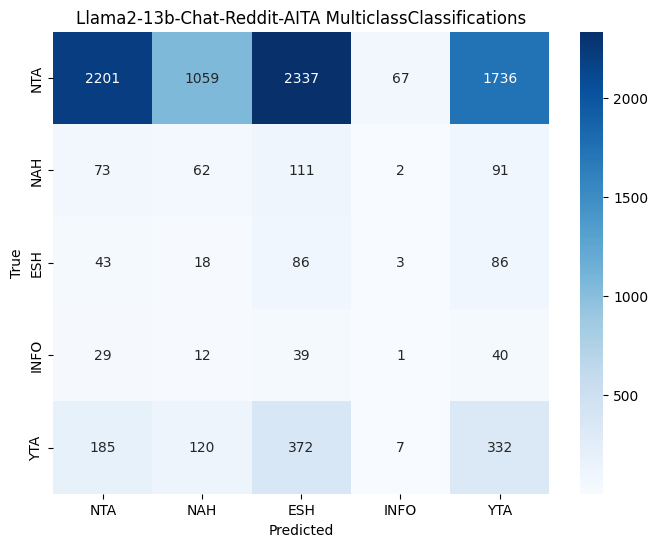

In [14]:
# run model evaluation

classification_type = 'multi'
output_files = [
    f'{results_directory}classification_report.txt',
    (confusion_matrix_title, f'{results_directory}confusion_matrix.png'),
    f'{results_directory}mcc.json',
    f'{results_directory}ROGUE_scores.json',
    f'{results_directory}BLEU_scores.json',
    f'{results_directory}COMET_scores.json'
]

Model_Evaluator.evaluate_model(
    submission_texts=submission_texts,
    predictions=predictions,
    references=references,
    AITA_classes=predicted_classes,
    correct_AITA_classes=correct_classes,
    ambiguity_scores=ambiguity_scores,
    classification_type=classification_type,
    output_files=output_files
)